<h1>Import all libraries</h1>

In [1]:
import re
import io

#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing

#For Decision Tree implementation
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#For KNN implementation
from sklearn.neighbors import KNeighborsClassifier

#For Bagging implementation
from sklearn.ensemble import BaggingClassifier

#For AdaBoost implementation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#For Random Forest implementation
from sklearn.ensemble import RandomForestClassifier


#Settings
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=np.nan)
sns.set()

<h1>Reading explored data into Dataframe</h1>

In [34]:
# Read from dataframe
df = pd.read_pickle("explored_data")
df = df.replace([np.inf, -np.inf, np.nan], 0) #removing infinite/nan values

# Check the columns using dtypes
print(df.dtypes)
# Randomly sample 5 records with .sample(5)
df.sample(5)

budget                 float64
revenue                float64
weekday                float64
day                    float64
month                  float64
year                   float64
runtime                float64
vote_average           float64
vote_count             float64
weighted_rating        float64
bin                    float64
log_revenue            float64
log_budget             float64
log_runtime            float64
log_vote_count         float64
log_vote_average       float64
log_weighted_rating    float64
dtype: object


,budget,revenue,weekday,day,month,year,runtime,vote_average,vote_count,weighted_rating,bin,log_revenue,log_budget,log_runtime,log_vote_count,log_vote_average,log_weighted_rating
12336,500000.00,8679814.00,7.00,26.00,1.00,2003.00,88.00,7.50,290.00,7.01,4.00,15.98,13.12,4.48,5.67,2.01,1.95
7538,0.00,270000.00,5.00,14.00,6.00,2002.00,50.00,0.00,0.00,7.00,2.00,12.51,0.00,3.91,0.00,0.00,1.95
15736,5000000.00,151449.00,1.00,21.00,5.00,2007.00,85.00,6.10,75.00,7.00,2.00,11.93,15.42,4.44,4.32,1.81,1.95
15617,45000000.00,72028752.00,3.00,23.00,11.00,2005.00,90.00,5.80,390.00,6.98,5.00,18.09,17.62,4.50,5.97,1.76,1.94
5085,100000000.00,723192705.00,5.00,5.00,8.00,2016.00,0.00,6.30,4.00,7.00,5.00,20.40,18.42,0.00,1.39,1.84,1.95


In [30]:
#Decision Tree in SKLearn don't take in string well. So we use a label encoder to change that string to a numeric value
"""
for column in df.columns:
    if df[column].dtype == type(object):
        #Create the label encoder
        le = preprocessing.LabelEncoder()
        #Convert the non numeric data to numeric
        df[column] = le.fit_transform(df[column])
"""

<h1>Find out the number of records per revenue bin. </h1>

   bin     n
0 1.00  3502
1 2.00  3500
2 3.00  3502
3 4.00  3502
4 5.00  3505


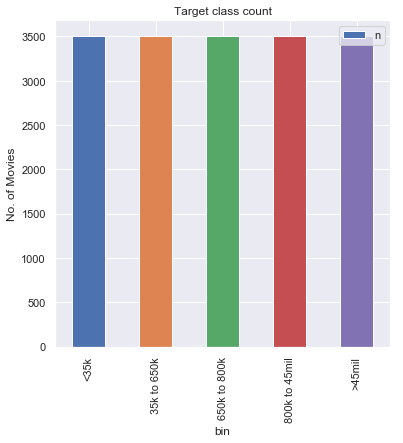

In [15]:
# Using groupby, find out the number of reviews with
# positive and negative sentiment respectively.
df_target = df.groupby('bin').size().reset_index(name='n')
print(df_target)

# How many patients in the dataset have been diagnosed positive and negative for diabetes?
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
df_target.plot(kind='bar', x='bin', y='n', title = "Target class count", ax=ax1)
ax1.set_ylabel("No. of Movies")
plt.xticks(np.arange(0,5), ["<35k", "35k to 650k", "650k to 800k", "800k to 45mil", ">45mil"])
plt.show()

<h1>Train-Test Split</h1>

In [88]:
X = df.loc[:, df.columns != 'bin']

y = df[['bin']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

<h1>k-Nearest Neighbor (KNN)</h1>

Refer to the following links on for detail explanation on the implementation:
- [kNN Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)



In [89]:
#Create the kNN classifier and set the number of neighbors. Note that you can tune this number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

#Fit the training feature Xs and training label Ys
knn.fit(X_train,y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = knn.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1    1023      15       1       0       0
true:2      19    1051       2       0       0
true:3       0       7    1053       2       0
true:4       0       0       8    1015       2
true:5       0       0       0       4    1052
Accuracy: 0.9885801294251998
F1 per Class: [0.98318116 0.97995338 0.99059266 0.99217986 0.9971564 ]


## Bagging (with Decision Tree)

Refer to the following links on for detail explanation on the implementation:
- [Bagging Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 

In [59]:
#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
baggingTree = BaggingClassifier(n_estimators=50)

#Fit the training feature Xs and training label Ys
baggingTree.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = baggingTree.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:0  pred:1  pred:2  pred:3  pred:4
true:0       0       0       0       0       0
true:1       0    1039       0       0       0
true:2       0       2    1070       0       0
true:3       0       0       0    1062       0
true:4       0       0       0       0    1025
Accuracy: 0.9996193376475067
F1 per Class: [0.99903846 0.99906629 1.         1.         1.        ]


## Bagging (with kNN)

In [60]:
#Create the kNN base classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
baggingknn = BaggingClassifier(n_estimators=50, base_estimator=knn)

#Fit the training feature Xs and training label Ys
baggingknn.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = baggingknn.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:0  pred:1  pred:2  pred:3  pred:4
true:0       0       0       0       0       0
true:1       0    1028      10       1       0
true:2       0      16    1054       2       0
true:3       0       0       7    1052       3
true:4       0       0       0       6    1019
Accuracy: 0.9906737723639132
F1 per Class: [0.98703793 0.98366776 0.9910504  0.99366163 0.99810247]


## AdaBoost (with Decision Tree)

Refer to the following links on for detail explanation on the implementation:
- [AdaBoost Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)
- [Setting Learning Rate and N Estimators](https://stats.stackexchange.com/questions/82323/shrinkage-parameter-in-adaboost)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 


In [83]:
#Create the AdaBoost classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
adaboostTree = AdaBoostClassifier(n_estimators=50,learning_rate=1)

#Fit the training feature Xs and training label Ys
adaboostTree.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = adaboostTree.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1    1039       0       0       0       0
true:2       2       0       0    1070       0
true:3       0       0       0    1062       0
true:4       0       0       0    1025       0
true:5       0       0       0       0    1056
Accuracy: 0.5938332698896079
F1 per Class: [0.99903846 0.         0.         0.49019608 1.        ]


C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## AdaBoost (with Gaussian Navie Bayes)
Refer to the following links on for detail explanation on the implementation:
- [Gaussian Naive Bayes Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Naive Bayes Classifier video](https://www.youtube.com/watch?v=CPqOCI0ahss)

In [80]:
naivebayes = GaussianNB()
#Fit the training feature Xs and training label Ys
naivebayes.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = naivebayes.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1    1032       0       5       2       0
true:2      39    1013      15       4       1
true:3       0      23    1010      27       2
true:4       0       0      26     971      28
true:5       0       0       0      93     963
Accuracy: 0.9495622382946327
F1 per Class: [0.97819905 0.96110057 0.95372993 0.91517436 0.9395122 ]


In [81]:
nb = GaussianNB()

adaboostnaivebayes = AdaBoostClassifier(n_estimators=50,learning_rate=1, base_estimator=nb)
#model = BaggingClassifier(n_estimators=50, base_estimator=knn)

#Fit the training feature Xs and training label Ys
adaboostnaivebayes.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = adaboostnaivebayes.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1    1012      27       0       0       0
true:2       1    1011      60       0       0
true:3       0       0    1021      41       0
true:4       0       0       0    1025       0
true:5       0       0       0       1    1055
Accuracy: 0.975256947087933
F1 per Class: [0.98635478 0.95829384 0.95286981 0.97992352 0.99952629]


## Ultimate Homework
As I mentioned in lecture, it is possible to ensemble different models. So how can we do that in python? Check out the following link and try it for your project!:
https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/ 

## Random Forest

In [78]:
#Instantiate model with 1000 decision trees
randomforest = RandomForestClassifier(n_estimators = 1000, random_state = 0)

#Fit the training feature Xs and training label Ys
randomforest.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = randomforest.predict(X_test)

# Find the confusion matrix of the result
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
    index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
    columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
print("Confusion Matrix")
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
print("Accuracy:",asr)
print("F1 per Class:", f1)

Confusion Matrix
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1    1039       0       0       0       0
true:2       2    1070       0       0       0
true:3       0       0    1062       0       0
true:4       0       0       0    1025       0
true:5       0       0       0       0    1056
Accuracy: 0.9996193376475067
F1 per Class: [0.99903846 0.99906629 1.         1.         1.        ]
